# データサイエンス基礎(with Titanic)

この問題は Kaggle https://www.kaggle.com/ のチュートリアル課題で、データサイエンスの手順を学習するためのサンプルでもあります。  
ここではそのデータを例に、実際のデータサイエンスの手順を学習してみます。

課題の Titanic は学習データと問題データが用意されており、学習データにだけ 「生存有無」 のフラグがあります。  
ここから機械学習による判定機か、判定のためのモデルを作成し、問題データ内の生死不明乗客が生き残ったかどうかを判定します。

データサイエンスの基礎の流れは以下の流れのようです。

1. データの概要確認
2. 各データの内容を確認
3. データ変換/データ補正/削除など
4. 学習モデルの作成
5. 判定データの作成

これらの流れを実際に行ってみます。

### 利用するライブラリの読み込み

In [1]:
# データ解析や加工
import pandas as pd
import numpy as np
import random as rnd

# 可視化ツール
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## データの読み取り

まずは読み込まなければ始まりません。  
学習に使うモデルは `12.datascience/input/train.csv` で、問題ファイルは `12.datascience/input/test.csv` として用意されています。

まずはこれを読み込みましょう。

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


各データの意味ですが

* PassengerId : 乗客ID
* Survived : 生き残ったかどうか
* Pclass : 部屋の等級
* Name : 氏名
* Sex : 性別
* Age : 年齢
* SibSp : タイタニックに同乗している兄弟/配偶者の数
* Parch : タイタニックに同乗している親/子供の数
* Ticket : チケット番号
* Fare : 料金
* Cabin : 客室番号
* Embarked : 乗った港

ということだそうです。  
どんなデータかわかったところで、データの状況を確認してみます。

## 各データの内容を確認

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


まずこの時点で Cabin の欠損量は冗談ではありません。  
これを補正なんて諦めた方がいいかも知れないので、潔く諦めてしまいましょう。

データの欠損がみられるのは Age / Fare / Cabin / Embarked だけですね。

次に考えるのは、これらを補正する価値があるのかどうかです。

### 年齢はどうだろうか？

年齢と生存率に何らかの有意性があるならば、補正する価値はありそうです。  
ということで、グラフを作成してみます。

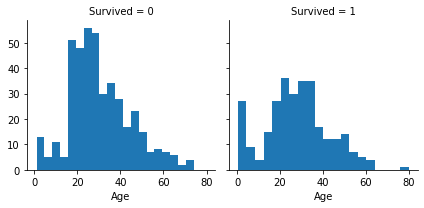

In [5]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

死亡した帯域と、生存した帯域で、20 台近辺はどちらも伸びてるので、単純に年齢層がそこに偏ってるだけだと考えられます。  
ただ、若年層の生存率は有意に高いですね。

これは補正してでも利用する価値はありそうです。

### Fare(料金)

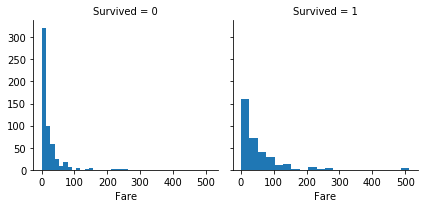

In [6]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

形に有意性があるようには見えませんね。  
ということで補正してまで使うのは諦めましょう。

### Cabin(客室番号)

In [7]:
train_df['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

…グラフにしなかったんじゃないです、できなかったんです。  
だって…ねぇ？えーって感じですよ。

グラフにせよ機械学習にせよ、単純なモデルで扱うには数字である必要があります。  
これ、どうしようもなくない？（汗

ということで、使いません（汗

### Embarked(乗船場所)

In [8]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

UNIQUE 3 ということは、３種類の値しか存在していないということ。  
であるならば、数字に置き換えることができます。

In [9]:
train_df['Embarked'].head(10)

0    S
1    C
2    S
3    S
4    S
5    Q
6    S
7    S
8    S
9    C
Name: Embarked, dtype: object

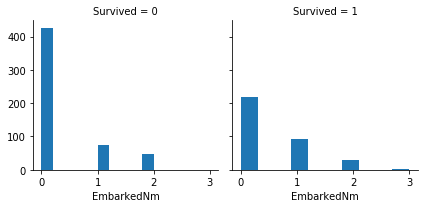

In [10]:
# S/C/Q しかないなら
def emverked_to_num(em):
    if em == 'S':
        return 0
    elif em == 'C':
        return 1
    elif em == 'Q':
        return 2
    else:
        return 3  # null のものが該当

train_df['EmbarkedNm'] = train_df['Embarked'].apply(emverked_to_num)

g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'EmbarkedNm')

これは傾向が別れましたね。  
乗船場所が 1:C, 2:Q の生存比率は、0:S の物より高そうです。

null のものを 3 として分離しましたが、運良く生存したものがわずかにいたようですね。  
であれば、無記名のものは 1:C と仮定して話を進めるのが良さそうです。

今度は欠損値を考えなくて良いデータも見てみましょう。

### PassengerId : 乗客ID

といってもさぁこれ

In [11]:
train_df['PassengerId'].head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

ただの連番じゃん…こんなの生存に関わるかよ（＝＝；  
関わったとしても使い道が思い浮かばない…

### Pclass : 部屋の等級

In [12]:
train_df['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

数字ならそのまま使える。

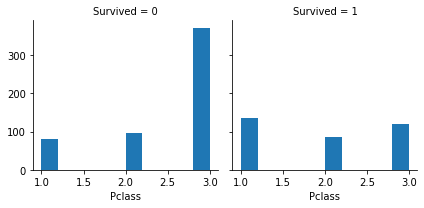

In [13]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Pclass')

有意差がありますね。


### Name : 氏名

Name ... はどう使っていいか迷いますね。  

In [14]:
train_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

定式化などはできませんが、手動でデータ補正をするとき、家族の推察には利用できそうですね。  
今回は諦めて捨ててしまいます。

### Sex : 性別

In [15]:
train_df[["Sex", "Survived"]]\
    .groupby(['Sex'], as_index=False)\
    .mean()\
    .sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


有意さとかそういうレベルではないです。  
グラフ作るまでもなくこの差…

### SibSp : タイタニックに同乗している兄弟/配偶者の数

In [16]:
train_df[["SibSp", "Survived"]]\
    .groupby(['SibSp'], as_index=False)\
    .mean()\
    .sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


これもグラフにするまでもなく有意差が出ますね。

### Parch : タイタニックに同乗している親/子供の数

* Ticket : チケット番号
* Cabin : 客室番号
* Embarked : 乗った港

In [17]:
train_df[["Parch", "Survived"]]\
    .groupby(['Parch'], as_index=False)\
    .mean()\
    .sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


これも差が出ますね…親が我が子を庇うとかそういう話でしょうか…。  
それを裏付けるように、数が増えると生存率が下がっていきます。

### Ticket : チケット番号

これも扱いに困りますね

In [18]:
train_df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

あーうん、無理！  
これ扱うの無理だわ！

という事で捨て捨て！

## データ変換/データ補正/削除など

さて、前述の結果から、消す物残す物、利用する物を順次決めていきます。  
まず、消すといった物を消していきましょう。

対象は

* PassengerId : 乗客ID
* Name : 氏名
* Ticket : チケット番号
* Fare : 料金
* Cabin : 客室番号

In [19]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1)
# PassengerId は回答用インデックスなので、削除しない
test_df = test_df.drop(['Name', 'Ticket', 'Fare', 'Cabin'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,EmbarkedNm
0,0,3,male,22.0,1,0,S,0
1,1,1,female,38.0,1,0,C,1
2,1,3,female,26.0,0,0,S,0
3,1,1,female,35.0,1,0,S,0
4,0,3,male,35.0,0,0,S,0


次に欠損値の補完を行いましょう。  
対象は「Age(年齢)」です。

方針としては3つ方策があります。

1. データを徹底的に眺めて、正しそうな値をマニュアルで補完する
2. とりあえず平均値の様な値で埋めてしまう
3. 欠損値を欠損を示す値に設定して処理を進めてしまう

ただし、３ の方法は、データの属性がラベル的な物である事が前提となります。  
はて、これは少しいい方向にながれそうです。

### データのクラス化

年齢に関して見ると、かなりバラバラの数値です。  
そのまま学習したところで、同じ年齢でなければ正しい判定が出てこない可能性があります。

そこで、一定の年齢範囲の単位でグループ化してしまいます。

前述のグラフを見る限り

* 5 才以下
* 6 - 15才
* 16 - 30才
* 31-60才
* それ以上

でクラス分類した方が良さそうな感じですね。  
このついでといってしまうとあれですが、欠損は別のラベルを振ってしまいます。

In [20]:
def class_with_age(age):
    if age < 5:
        return 0
    elif age < 16:
        return 1
    elif age < 30:
        return 2
    elif age < 60:
        return 3
    elif age != None:
        return 4
    else:
        return 5

train_df['Age'] = train_df['Age'].apply(class_with_age)
test_df['Age'] = test_df['Age'].apply(class_with_age)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,EmbarkedNm
0,0,3,male,2,1,0,S,0
1,1,1,female,3,1,0,C,1
2,1,3,female,2,0,0,S,0
3,1,1,female,3,1,0,S,0
4,0,3,male,3,0,0,S,0


次に、数字でない物を数字に変換しましょう。  
これは機械学習のモデルが文字列をどう扱っていいか不明になるためです。

In [21]:
def emverked_to_num(em):
    if em == 'S':
        return 0
    elif em == 'C':
        return 1
    elif em == 'Q':
        return 2
    else:
        return 1  # null のものが該当(test 側は null ではない)

train_df['EmbarkedNm'] = train_df['Embarked'].apply(emverked_to_num)
test_df['EmbarkedNm'] = test_df['Embarked'].apply(emverked_to_num)

train_df = train_df.drop(['Embarked'], axis=1)
test_df = test_df.drop(['Embarked'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,EmbarkedNm
0,0,3,male,2,1,0,0
1,1,1,female,3,1,0,1
2,1,3,female,2,0,0,0
3,1,1,female,3,1,0,0
4,0,3,male,3,0,0,0


In [22]:
def sex_to_num(v):
    return 1 if v == 'male' else 0

train_df['Sex'] = train_df['Sex'].apply(sex_to_num)
test_df['Sex'] = test_df['Sex'].apply(sex_to_num)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,EmbarkedNm
0,0,3,1,2,1,0,0
1,1,1,0,3,1,0,1
2,1,3,0,2,0,0,0
3,1,1,0,3,1,0,0
4,0,3,1,3,0,0,0


## 学習モデルの作成

本当ならここでこの学習データに対して複数の学習モデルを適用し、数値の良い物を利用するのですが、今回は面倒になってしまったので、RandomForest でお茶を濁します（苦笑）。

In [23]:
from sklearn.ensemble import RandomForestClassifier

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 6), (891,), (418, 6))

In [24]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

87.32

87% の正答率でしたか…もう少し上がればいいのですが（汗

## 問題を解いてみる

という事で、こうしてできた学習機に実際に回答させてみます。

In [25]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submission.csv', index=False)